In [1]:
import os
import pandas as pd
from IPython.display import display
# import numpy as np
# import chardet
import matplotlib
import matplotlib.pyplot as plt
import gspread_pandas
import gspread
import gspread_dataframe as gd
from google.api_core.retry import Retry
# from oauth2client.service_account import ServiceAccountCredentials
# from google.auth.transport.requests import AuthorizedSession
# from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials
from firebase_admin import credentials as firebase_credentials, storage, initialize_app


In [9]:
# Google Cloud Console에 대한 서비스 키
creds_path = "C:/Users/admin/Desktop/voice_data_queries/samboss-reward-394470968e63.json"

# Spreadsheet ID는 해당 url 주소의 d와 edit 사이의 값
# spreadsheet_id = "1XMjIScbWqyiyzGMfOk5jvbAQ_ys8Srg8e60R6BkqMJ4"  # fs_point_20230801 시트
spreadsheet_id = "1fstoqfCCyIv38D4ZOxicoDdIaLhcfuXOf_9yn-ijn_U"   # fs_memo_20230801 시트

# Google Drive API와 Google Sheets API에 연결하고 인증
creds = Credentials.from_service_account_file(creds_path)
drive_service = build('drive', 'v3', credentials=creds)     # ( 사용하려는 API, API 버전, 인증 )
sheets_service = build('sheets', 'v4', credentials=creds)

# Spreadsheet에 대한 메타데이터
spreadsheet_metadata = sheets_service.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()

In [10]:
# 시트의 이름을 지정 (예: 'Sheet1')
sheet_name = '시트1'

# # 범위를 지정 (예: 'Sheet1!A1:D10')
# range_name = f'{sheet_name}!A1:C10'
range_name = sheet_name  # 범위를 시트 이름만으로 지정 -> 전체 시트

# 시트의 내용 가져오기
sheet = sheets_service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()

# 결과를 Pandas DataFrame으로 변환
df = pd.DataFrame(sheet.get('values', []))

# 첫 번째 행을 열 이름으로 사용
df.columns = df.iloc[0]
df = df.iloc[1:]

# 결과 확인
print(df)

0           ageArray category   cnt    collection                 date  \
1                 []       기타  5000  Memorization  23.06.19 - 23.06.30   
2                 []       기타  5000  Memorization  23.06.19 - 23.06.30   
3     ['30대', '40대']       기타  5000  Memorization  23.06.19 - 23.06.30   
4                 []       기타  5000  Memorization  23.06.19 - 23.06.30   
5                 []       기타  5000  Memorization  23.06.19 - 23.06.30   
...              ...      ...   ...           ...                  ...   
5295  ['30대', '40대']       기타  1500  Memorization  23.08.03 - 23.08.03   
5296              []       기타  1500  Memorization  23.08.03 - 23.08.03   
5297              []       기타  5000  Memorization  23.07.29 - 23.08.06   
5298              []       기타  5000  Memorization  23.07.29 - 23.08.06   
5299              []       기타  5000  Memorization  23.07.31 - 23.08.28   

0      dateEnd                                          descArray engineArray  \
1     23.06.15  ['https://fire

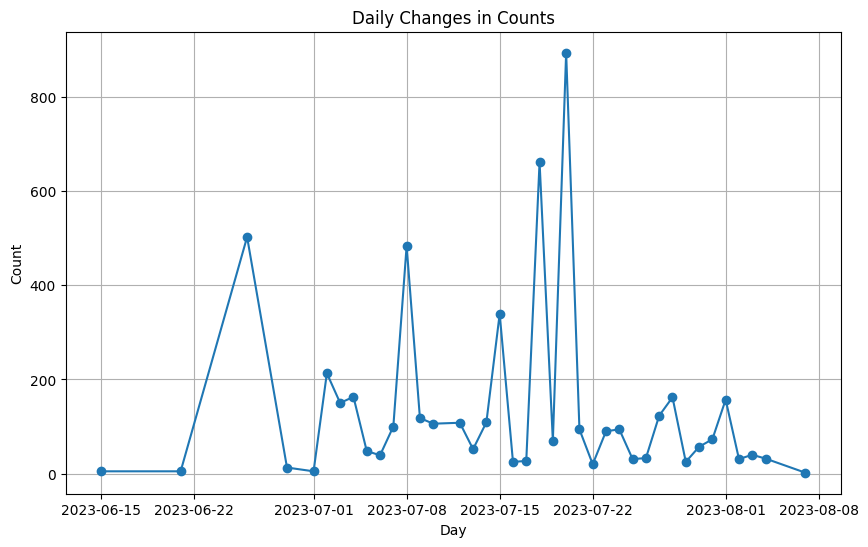

In [19]:
# # 월별 ( POINT )
# # 'dateEnd' 컬럼을 datetime 자료형으로 변환
# df['dateEnd'] = pd.to_datetime(df['dateEnd'], format='%y.%m.%d')

# # 2023년 9월 이후 자료 제외
# df = df[df['dateEnd'] < '2023-09-01']

# # 'dateEnd' 컬럼을 월별로 그룹화하고 각 그룹의 크기를 계산
# monthly_counts = df.groupby(df['dateEnd'].dt.to_period("M")).size()

# # 월별 카운트를 다시 DataFrame으로 변환
# monthly_counts_df = monthly_counts.reset_index()
# monthly_counts_df['dateEnd'] = monthly_counts_df['dateEnd'].dt.to_timestamp()
# monthly_counts_df.columns = ['dateEnd', 'count']

# # 그래프 그리기
# plt.figure(figsize=[10,6])
# plt.plot(monthly_counts_df['dateEnd'], monthly_counts_df['count'], marker='o')
# plt.title('Monthly Changes in Counts')
# plt.xlabel('Month')
# plt.ylabel('Count')
# plt.grid(True)
# plt.show()
#######################################################################################

# 일별
# 'dateEnd' 컬럼을 datetime 자료형으로 변환
df['dateEnd'] = pd.to_datetime(df['dateEnd'], format='%y.%m.%d')

# 2023년 9월 이후 자료 제외
df = df[df['dateEnd'] < '2023-08-09']

# 'dateEnd' 컬럼을 일별로 그룹화하고 각 그룹의 크기를 계산
daily_counts = df.groupby(df['dateEnd'].dt.to_period("D")).size()

# 일별 카운트를 다시 DataFrame으로 변환
daily_counts_df = daily_counts.reset_index()
daily_counts_df['dateEnd'] = daily_counts_df['dateEnd'].dt.to_timestamp()
daily_counts_df.columns = ['dateEnd', 'count']

# 그래프 그리기
plt.figure(figsize=[10,6])
plt.plot(daily_counts_df['dateEnd'], daily_counts_df['count'], marker='o')
plt.title('Daily Changes in Counts')
plt.xlabel('Day')
plt.ylabel('Count')
plt.grid(True)
plt.show()



# # 'dateEnd' 컬럼의 최소값과 최대값을 확인
# print(df['dateEnd'].min())
# print(df['dateEnd'].max())

# # 'dateEnd' 컬럼을 월별로 그룹화하고 각 그룹의 크기를 계산하여 출력
# print(df.groupby(df['dateEnd'].dt.to_period("M")).size())

# # 'dateEnd' 컬럼의 유니크한 값들을 출력
# print(df['dateEnd'].unique())

# print(monthly_counts_df)


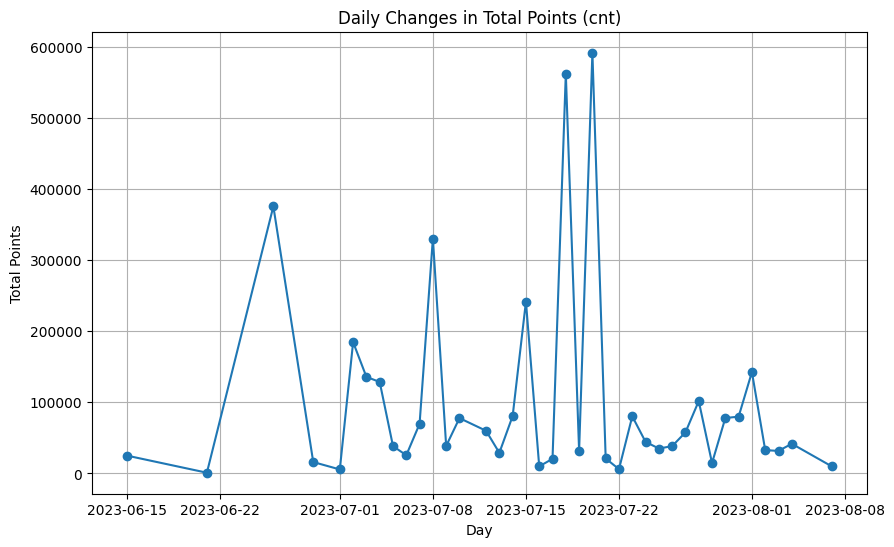

In [20]:
# # 월별 ( POINT )
# # 'cnt' 컬럼을 정수로 변환
# df['cnt'] = df['cnt'].astype(int)

# # 'dateEnd' 컬럼을 월별로 그룹화하고 'cnt' 컬럼의 합계를 계산
# monthly_cnt_sum = df.groupby(df['dateEnd'].dt.to_period("M"))['cnt'].sum()

# # 월별 합계를 다시 DataFrame으로 변환
# monthly_cnt_sum_df = monthly_cnt_sum.reset_index()
# monthly_cnt_sum_df['dateEnd'] = monthly_cnt_sum_df['dateEnd'].dt.to_timestamp()
# monthly_cnt_sum_df.columns = ['dateEnd', 'total_cnt']

# # 그래프 그리기
# plt.figure(figsize=[10,6])
# plt.plot(monthly_cnt_sum_df['dateEnd'], monthly_cnt_sum_df['total_cnt'], marker='o')
# plt.title('Monthly Changes in Total Points (cnt)')
# plt.xlabel('Month')
# plt.ylabel('Total Points')
# plt.grid(True)
# plt.show()

########################################################################################

# 일별
# 'cnt' 컬럼을 정수로 변환
df['cnt'] = df['cnt'].astype(int)

# 'dateEnd' 컬럼을 일별로 그룹화하고 'cnt' 컬럼의 합계를 계산
daily_cnt_sum = df.groupby(df['dateEnd'].dt.to_period("D"))['cnt'].sum()

# 일별 합계를 다시 DataFrame으로 변환
daily_cnt_sum_df = daily_cnt_sum.reset_index()
daily_cnt_sum_df['dateEnd'] = daily_cnt_sum_df['dateEnd'].dt.to_timestamp()
daily_cnt_sum_df.columns = ['dateEnd', 'total_cnt']

# 그래프 그리기
plt.figure(figsize=[10,6])
plt.plot(daily_cnt_sum_df['dateEnd'], daily_cnt_sum_df['total_cnt'], marker='o')
plt.title('Daily Changes in Total Points (cnt)')
plt.xlabel('Day')
plt.ylabel('Total Points')
plt.grid(True)
plt.show()


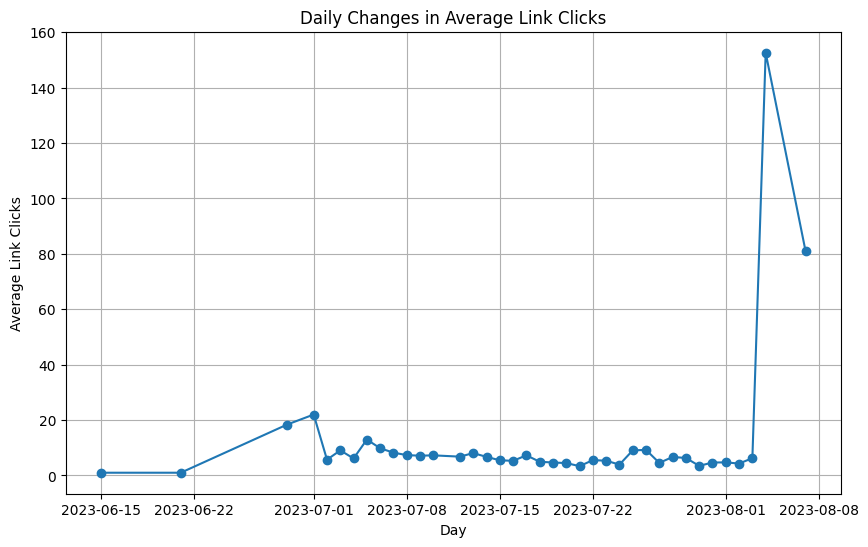

In [21]:
# # 월별( POINT )
# # 공백 값을 0으로 변환
# df['linkClick'].replace('', '0', inplace=True)
# df['linkClickDesc'].replace('', '0', inplace=True)

# # 'linkClick'과 'linkClickDesc' 컬럼을 정수로 변환
# df['linkClick'] = df['linkClick'].astype(int)
# df['linkClickDesc'] = df['linkClickDesc'].astype(int)

# # 두 컬럼의 합계를 계산
# df['total_link_clicks'] = df['linkClick'] + df['linkClickDesc']

# # 둘 다 0인 행은 제외
# df_filtered = df[df['total_link_clicks'] > 0]

# # 'dateEnd' 컬럼을 월별로 그룹화하고 'total_link_clicks' 컬럼의 평균을 계산
# monthly_click_avg = df_filtered.groupby(df_filtered['dateEnd'].dt.to_period("M"))['total_link_clicks'].mean()

# # 월별 평균을 다시 DataFrame으로 변환
# monthly_click_avg_df = monthly_click_avg.reset_index()
# monthly_click_avg_df['dateEnd'] = monthly_click_avg_df['dateEnd'].dt.to_timestamp()
# monthly_click_avg_df.columns = ['dateEnd', 'avg_clicks']

# # 그래프 그리기
# plt.figure(figsize=[10,6])
# plt.plot(monthly_click_avg_df['dateEnd'], monthly_click_avg_df['avg_clicks'], marker='o')
# plt.title('Monthly Changes in Average Link Clicks')
# plt.xlabel('Month')
# plt.ylabel('Average Link Clicks')
# plt.grid(True)
# plt.show()

##############################################################################################################

# 일별 ( MEMO )
# 공백 값을 0으로 변환
df['linkClick'].replace('', '0', inplace=True)
df['linkClickDesc'].replace('', '0', inplace=True)

# 'linkClick'과 'linkClickDesc' 컬럼을 정수로 변환
df['linkClick'] = df['linkClick'].astype(int)
df['linkClickDesc'] = df['linkClickDesc'].astype(int)

# 두 컬럼의 합계를 계산
df['total_link_clicks'] = df['linkClick'] + df['linkClickDesc']

# 둘 다 0인 행은 제외
df_filtered = df[df['total_link_clicks'] > 0]

# 'dateEnd' 컬럼을 일별로 그룹화하고 'total_link_clicks' 컬럼의 평균을 계산
daily_click_avg = df_filtered.groupby(df_filtered['dateEnd'].dt.to_period("D"))['total_link_clicks'].mean()

# 일별 평균을 다시 DataFrame으로 변환
daily_click_avg_df = daily_click_avg.reset_index()
daily_click_avg_df['dateEnd'] = daily_click_avg_df['dateEnd'].dt.to_timestamp()
daily_click_avg_df.columns = ['dateEnd', 'avg_clicks']

# 그래프 그리기
plt.figure(figsize=[10,6])
plt.plot(daily_click_avg_df['dateEnd'], daily_click_avg_df['avg_clicks'], marker='o')
plt.title('Daily Changes in Average Link Clicks')
plt.xlabel('Day')
plt.ylabel('Average Link Clicks')
plt.grid(True)
plt.show()


In [22]:
# 'total_link_clicks'를 기준으로 내림차순 정렬하고 상위 20개 행을 선택
top_20_clicks = df.nlargest(20, 'total_link_clicks')

# 상위 20개 행의 ID 컬럼을 추출
top_20_ids_and_dates = top_20_clicks[['id', 'date', 'point','total_link_clicks']]

# top_20_ids_and_dates = top_20_ids_and_dates.sort_values(by='total_link_clicks', ascending=False)

# 결과 출력
display(top_20_ids_and_dates)

,id,date,point,total_link_clicks
5296,화환 근조화환 축하화환 개업 화분 결혼식 장례 장례식조화 근조화 전국꽃배달서비스 1...,23.08.03 - 23.08.03,20,282
5289,철제선반 베란다선반 조립식앵글 메탈 고릴라랙 산업용 프레스랙 400X300X1200...,23.08.03 - 23.08.03,15,269
5286,전자담배 액상 전담액상 사이트 입호흡 발라리안 맥스 알로에베라 액상 30ml 15409,23.08.03 - 23.08.03,15,267
5285,전자담배 액상 사이트 전담액상 입호흡 발라리안 알로에베라 액상 100ml 15410,23.08.03 - 23.08.03,15,264
5266,[MUH] 엠유에이치 리바이탈라이징 윙클 스팟 아이크림 15396,23.08.03 - 23.08.03,15,188
3342,여자들이 무조건 잡아야 하는 남자 0001,23.07.09 - 23.07.19,80,178
5272,몬스터펀치 전자담배액상 전담액상 입호흡 완성형 알로에베라 15306,23.08.03 - 23.08.03,15,171
1244,보미새가 좋아하는 훈민정음,23.06.28 - 23.07.07,50,166
5287,전자담배액상 사이트 전담액상 입호흡액상 워터밤30ml 15304,23.08.03 - 23.08.03,15,164
5279,에브리 일회용 전자담배 나잇 대용량 편의점 전담 민트 12ml 15319,23.08.03 - 23.08.03,15,158


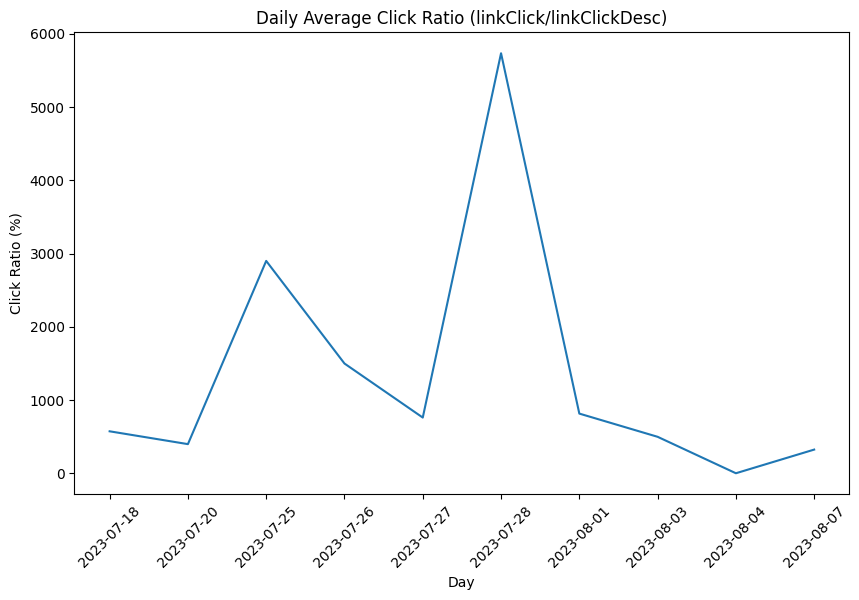

In [23]:
# # 월별 ( POINT sheet )
# # 'dateEnd' 컬럼을 월별로 그룹화하고 'cnt' 컬럼의 합계를 계산
# monthly_cnt_sum = df.groupby(df['dateEnd'].dt.to_period("M"))['cnt'].sum().reset_index()

# # linkClickDesc가 0이 아닌 행만 선택하고 복사
# non_zero_df = df[df['linkClickDesc'] != 0].copy()

# # 비율 계산
# non_zero_df['click_ratio'] = (non_zero_df['linkClick'] / non_zero_df['linkClickDesc']) * 100

# # 'dateEnd'를 월로 변환
# non_zero_df['month'] = non_zero_df['dateEnd'].dt.to_period("M")

# # 월별로 평균 계산
# monthly_avg = non_zero_df.groupby('month')['click_ratio'].mean().reset_index()

# # 그래프 그리기
# plt.figure(figsize=[10,6])
# plt.plot(monthly_avg['month'].astype(str), monthly_avg['click_ratio'])
# plt.xlabel('Month')
# plt.ylabel('Click Ratio (%)')
# plt.title('Monthly Average Click Ratio (linkClick/linkClickDesc)')
# plt.xticks(rotation=45)
# plt.show()

#################################################################################################

# 'dateEnd' 컬럼을 일별로 그룹화하고 'cnt' 컬럼의 합계를 계산
daily_cnt_sum = df.groupby(df['dateEnd'].dt.to_period("D"))['cnt'].sum().reset_index()

# linkClickDesc가 0이 아닌 행만 선택하고 복사
non_zero_df = df[df['linkClickDesc'] != 0].copy()

# 비율 계산
non_zero_df['click_ratio'] = (non_zero_df['linkClick'] / non_zero_df['linkClickDesc']) * 100

# 'dateEnd'를 일로 변환
non_zero_df['day'] = non_zero_df['dateEnd'].dt.to_period("D")

# 일별로 평균 계산
daily_avg = non_zero_df.groupby('day')['click_ratio'].mean().reset_index()

# 그래프 그리기
plt.figure(figsize=[10,6])
plt.plot(daily_avg['day'].astype(str), daily_avg['click_ratio'])
plt.xlabel('Day')
plt.ylabel('Click Ratio (%)')
plt.title('Daily Average Click Ratio (linkClick/linkClickDesc)')
plt.xticks(rotation=45)
plt.show()


count       660.000000
mean       4756.652203
std       12357.109889
min           0.000000
25%         175.000000
50%         600.000000
75%        1800.000000
max      106700.000000
Name: click_ratio, dtype: float64


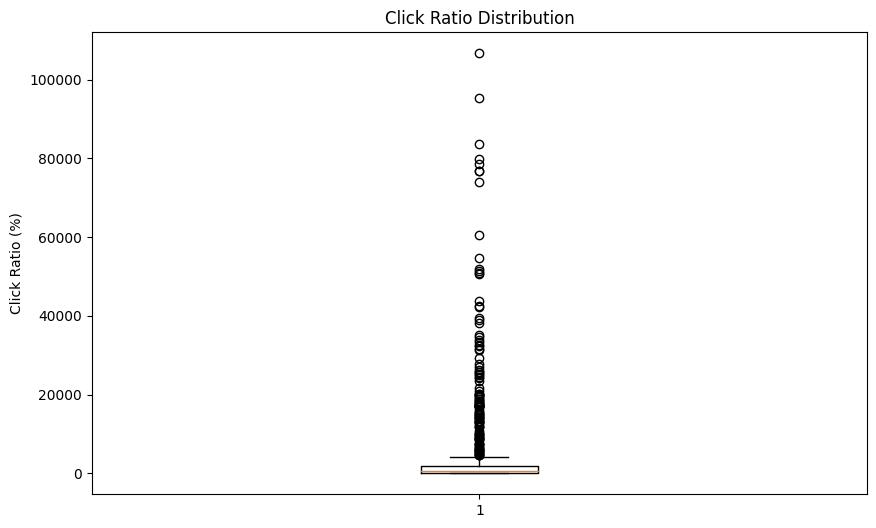

,id,linkClick,linkClickDesc
797,요즘 대세 스마트 세면도구 키트,1067,1
897,"일산 웨딩, 혼수, 신혼여행박람회",954,1
878,"이사 준비, 비법을 알려드립니다!",837,1
902,임금 체불? 참지마세요!,798,1
123,경력단절여성 취업지원,786,1
836,"위기 상황, 골든타임을 확보하라",768,1
434,발견 즉시 온라인으로 신고하기!,767,1
126,고용안정 강소기업을 찾아서!,740,1
533,생태가 5천원,605,1
84,간편하게 식자재 주문하고 당일 배송 받기!,1092,2


In [57]:
# 기술 통계량 확인
print(non_zero_df['click_ratio'].describe())

# 박스 플롯으로 이상치 시각화
plt.figure(figsize=[10,6])
plt.boxplot(non_zero_df['click_ratio'])
plt.title('Click Ratio Distribution')
plt.ylabel('Click Ratio (%)')
plt.show()


# linkClickDesc가 0이 아닌 행만 선택하고 복사
non_zero_df = df[df['linkClickDesc'] != 0].copy()

# 비율 계산
non_zero_df['click_ratio'] = (non_zero_df['linkClick'] / non_zero_df['linkClickDesc']) * 100

# 상위 20개의 광고를 click_ratio 기준으로 선택
top_20_click_ratio = non_zero_df.nlargest(20, 'click_ratio')

# 원하는 컬럼만 선택해서 출력
display(top_20_click_ratio[['id', 'linkClick', 'linkClickDesc']])